In [2]:
from plancraft.environments.env_real import RealPlancraft

env = RealPlancraft(
    inventory=[{"type": "beetroot_soup", "quantity": 1, "slot": 45}],
    symbolic_action_space=True,
    symbolic_observation_space=True,
    resolution=[512, 512],
    crop=True,
)
data = []

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


In [1]:
import torch
from train_fast_rcnn import M1, M2, prepare_m2_batch, sample_environment

# m1_path = "m1.pth"
# m2_path = "m2.pth"
# M1_model = M1(weights_path = m1_path)
# M1_model = M1_model.cuda()
M2_model = M2()
M2_model = M2_model.cuda()
print("Loaded model")

N = 1000
lr = 0.001
batch_size = 4
save_every = 100
count = 0
# m1_optimizer = torch.optim.AdamW(M1_model.parameters(), lr=lr)
m2_optimizer = torch.optim.AdamW(M2_model.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded model


In [2]:
for images, targets, raw_images, inv in sample_environment(N=N, batch_size=batch_size):
        break

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'minerl.utils.process_watcher' found in sys.modules after import of package 'minerl.utils', but prior to execution of 'minerl.utils.process_watcher'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


Env loaded


In [3]:
from PIL import Image

# train M2
for img, inventory in zip(raw_images, inv):
    i = Image.fromarray(img.copy())
    m2_batch = prepare_m2_batch(i, inventory)
    m2_batch["bbox_tensors"] = torch.stack(m2_batch["bbox_tensors"]).cuda()
    m2_batch["item_quantity"] = m2_batch["item_quantity"].unsqueeze(1).cuda()
    m2_batch["item_locations"] = m2_batch["item_locations"].cuda()
    m2_batch["item_types"] = m2_batch["item_types"].cuda()
    break
    # M2_model.train()
    # M2_model(m2_batch)
    # losses = sum(loss for loss in loss_dict.values())
    # m2_optimizer.zero_grad()
    # losses.backward()
    # m2_optimizer.step()

# N = len(m2_batch["item_types"])
# encoded_img = M2_model.img_encoder(m2_batch["bbox_tensors"]).reshape(N, -1)

# M2_model.quantity_encoder(m2_batch["item_quantity"].unsqueeze(1))

# m2_batch["item_quantity"].shape
# 
# m2_batch["item_quantity"]


In [112]:
import glob
from PIL import Image
import numpy as np


image_paths = glob.glob("data/oracle/train/imgs/*.png")
# load images
image_arrays = [Image.open(p) for p in image_paths]
# to tensor
image_tensors = [np.array(i)/255 for i in image_arrays]

# stack
image_tensors = np.stack(image_tensors)

In [115]:
image_tensors_mean = image_tensors.mean(axis=(0, 1, 2))
image_tensors_std = image_tensors.std(axis=(0, 1, 2))
print(image_tensors_mean, image_tensors_std)

[0.63818245 0.63606814 0.63203097] [0.20783292 0.21012318 0.21597961]


In [117]:
from minerl.herobraine.hero.mc import ALL_ITEMS

'air'

In [6]:
from typing import Dict, List
import torch.nn as nn
from torchvision.models.detection.roi_heads import (
    RoIHeads,
    fastrcnn_loss,
    maskrcnn_loss,
    maskrcnn_inference,
    keypointrcnn_loss,
    keypointrcnn_inference,
)


class OverrideRoIHeads(RoIHeads):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.quantity_predictor = nn.Sequential(nn.Linear(1024, 1), nn.Sigmoid())

    def forward(
        self,
        features,  # type: Dict[str, Tensor]
        proposals,  # type: List[Tensor]
        image_shapes,  # type: List[Tuple[int, int]]
        targets=None,  # type: Optional[List[Dict[str, Tensor]]]
    ):
        """
        Args:
            features (List[Tensor])
            proposals (List[Tensor[N, 4]])
            image_shapes (List[Tuple[H, W]])
            targets (List[Dict])
        """
        if targets is not None:
            for t in targets:
                # TODO: https://github.com/pytorch/pytorch/issues/26731
                floating_point_types = (torch.float, torch.double, torch.half)
                if not t["boxes"].dtype in floating_point_types:
                    raise TypeError(
                        f"target boxes must of float type, instead got {t['boxes'].dtype}"
                    )
                if not t["labels"].dtype == torch.int64:
                    raise TypeError(
                        f"target labels must of int64 type, instead got {t['labels'].dtype}"
                    )
                if self.has_keypoint():
                    if not t["keypoints"].dtype == torch.float32:
                        raise TypeError(
                            f"target keypoints must of float type, instead got {t['keypoints'].dtype}"
                        )

        if self.training:
            proposals, matched_idxs, labels, regression_targets = (
                self.select_training_samples(proposals, targets)
            )
        else:
            labels = None
            regression_targets = None
            matched_idxs = None

        box_features = self.box_roi_pool(features, proposals, image_shapes)
        box_features = self.box_head(box_features)
        class_logits, box_regression = self.box_predictor(box_features)
        quantity_logits = self.quantity_predictor(box_features)

        result: List[Dict[str, torch.Tensor]] = []
        losses = {}
        if self.training:
            if labels is None:
                raise ValueError("labels cannot be None")
            if regression_targets is None:
                raise ValueError("regression_targets cannot be None")
            loss_classifier, loss_box_reg = fastrcnn_loss(
                class_logits, box_regression, labels, regression_targets
            )


            losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
        else:
            boxes, scores, labels = self.postprocess_detections(
                class_logits, box_regression, proposals, image_shapes
            )
            num_images = len(boxes)
            for i in range(num_images):
                result.append(
                    {
                        "boxes": boxes[i],
                        "labels": labels[i],
                        "scores": scores[i],
                    }
                )

        if self.has_mask():
            mask_proposals = [p["boxes"] for p in result]
            if self.training:
                if matched_idxs is None:
                    raise ValueError("if in training, matched_idxs should not be None")

                # during training, only focus on positive boxes
                num_images = len(proposals)
                mask_proposals = []
                pos_matched_idxs = []
                for img_id in range(num_images):
                    pos = torch.where(labels[img_id] > 0)[0]
                    mask_proposals.append(proposals[img_id][pos])
                    pos_matched_idxs.append(matched_idxs[img_id][pos])
            else:
                pos_matched_idxs = None

            if self.mask_roi_pool is not None:
                mask_features = self.mask_roi_pool(features, mask_proposals, image_shapes)
                mask_features = self.mask_head(mask_features)
                mask_logits = self.mask_predictor(mask_features)
            else:
                raise Exception("Expected mask_roi_pool to be not None")

            loss_mask = {}
            if self.training:
                if targets is None or pos_matched_idxs is None or mask_logits is None:
                    raise ValueError(
                        "targets, pos_matched_idxs, mask_logits cannot be None when training"
                    )

                gt_masks = [t["masks"] for t in targets]
                gt_labels = [t["labels"] for t in targets]
                rcnn_loss_mask = maskrcnn_loss(
                    mask_logits, mask_proposals, gt_masks, gt_labels, pos_matched_idxs
                )
                loss_mask = {"loss_mask": rcnn_loss_mask}
            else:
                labels = [r["labels"] for r in result]
                masks_probs = maskrcnn_inference(mask_logits, labels)
                for mask_prob, r in zip(masks_probs, result):
                    r["masks"] = mask_prob

            losses.update(loss_mask)

        # keep none checks in if conditional so torchscript will conditionally
        # compile each branch
        if (
            self.keypoint_roi_pool is not None
            and self.keypoint_head is not None
            and self.keypoint_predictor is not None
        ):
            keypoint_proposals = [p["boxes"] for p in result]
            if self.training:
                # during training, only focus on positive boxes
                num_images = len(proposals)
                keypoint_proposals = []
                pos_matched_idxs = []
                if matched_idxs is None:
                    raise ValueError("if in trainning, matched_idxs should not be None")

                for img_id in range(num_images):
                    pos = torch.where(labels[img_id] > 0)[0]
                    keypoint_proposals.append(proposals[img_id][pos])
                    pos_matched_idxs.append(matched_idxs[img_id][pos])
            else:
                pos_matched_idxs = None

            keypoint_features = self.keypoint_roi_pool(
                features, keypoint_proposals, image_shapes
            )
            keypoint_features = self.keypoint_head(keypoint_features)
            keypoint_logits = self.keypoint_predictor(keypoint_features)

            loss_keypoint = {}
            if self.training:
                if targets is None or pos_matched_idxs is None:
                    raise ValueError(
                        "both targets and pos_matched_idxs should not be None when in training mode"
                    )

                gt_keypoints = [t["keypoints"] for t in targets]
                rcnn_loss_keypoint = keypointrcnn_loss(
                    keypoint_logits, keypoint_proposals, gt_keypoints, pos_matched_idxs
                )
                loss_keypoint = {"loss_keypoint": rcnn_loss_keypoint}
            else:
                if keypoint_logits is None or keypoint_proposals is None:
                    raise ValueError(
                        "both keypoint_logits and keypoint_proposals should not be None when not in training mode"
                    )

                keypoints_probs, kp_scores = keypointrcnn_inference(
                    keypoint_logits, keypoint_proposals
                )
                for keypoint_prob, kps, r in zip(keypoints_probs, kp_scores, result):
                    r["keypoints"] = keypoint_prob
                    r["keypoints_scores"] = kps
            losses.update(loss_keypoint)

        return result, losses
    


from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2

model = fasterrcnn_resnet50_fpn_v2(pretrained=True)
model.roi_heads = OverrideRoIHeads(model.roi_heads.box_roi_pool, model.roi_heads.box_head, model.roi_heads.box_predictor, model.roi_heads)



In [4]:
import torch
import torch.nn as nn   
import torch.nn.functional as F
from torchvision.models.detection.faster_rcnn import fasterrcnn_resnet50_fpn_v2
from minerl.herobraine.hero.mc import ALL_ITEMS

class M2(nn.Module):
    def __init__(self):
        super(M2, self).__init__()
        self.box_feats = None
        self.proposals = None
        self.image_shapes = None

        self.model = fasterrcnn_resnet50_fpn_v2(
            pretrained=False,
            image_mean=[0.63, 0.63, 0.63],
            image_std=[0.21, 0.21, 0.21],
            min_size=64,
            max_size=64,
            num_classes=len(ALL_ITEMS),
        )

        # need to save the intermediate features
        # self.model.roi_heads.box_predictor.cls_score.register_pre_forward_hook(
        self.model.roi_heads.box_roi_pool.register_forward_pre_hook(
            self.save_prop_img_shape
        )
        self.model.roi_heads.box_predictor.register_forward_hook(self.save_box_feats)
        # self.model.roi_heads.box_predictor.bbox_pred.register_forward_pre_hook(
        #     self.save_feats
        # )
        self.quantity_prediction = nn.Sequential(nn.Linear(1024, 1), nn.Sigmoid())
        
    def save_prop_img_shape(self, _module, input):
        # Save the input features to be used later
        self.proposals = input[1]
        print("self.proposals", self.proposals[0].shape)
        self.image_shapes = input[2]
        # print("self.proposals", self.proposals.shape)
        # print("self.image_shapes", self.image_shapes)
    
    def save_box_feats(self, _module, input, output):
        self.box_feats = input[0]
        self.class_logits = output[0]

    def forward(self, x, targets=None, quantity_targets=None):
        if self.training:
            # assert targets is not None and quantity_targets is not None
            print(self.box_feats)
            loss_dict = self.model(x, targets)
            print("box_feats", self.box_feats.shape)
            print("class_logits", self.class_logits.shape)
            print("targets", targets["labels"])


            # custom_classification_loss = F.cross_entropy(
            #     self.class_logits, targets["labels"]
            # )
            # print(custom_classification_loss)

            # loss_classifier 
            # Compute the loss for the quantity classifier
            # predicted_quantities = self.quantity_prediction(self.feats)
            # loss_dict["quantity_loss"] = F.mse_loss(predicted_quantities, quantity_targets)
            return loss_dict
        else:
            print(self.box_feats)
            preds = self.model(x)
            print(self.box_feats.shape)
            # preds["predicted_quantities"] = self.quantity_prediction(
            #     self.feats
            # )
            return preds

m = M2()
m.train()
m.cuda()

fake_inputs = [torch.rand(3, 64, 64).cuda(), torch.rand(3, 64, 64).cuda()]
fake_targets = [
    {
        "boxes": torch.tensor([[10, 10, 20, 20], [30, 30, 40, 40]]).cuda(),
        "labels": torch.tensor([1, 2]).cuda(),
    },
    {
        "boxes": torch.tensor([[10, 10, 20, 20], [30, 30, 40, 40]]).cuda(),
        "labels": torch.tensor([1, 2]).cuda(),
    },
]

m(fake_inputs, targets=fake_targets)

None
LABELS
torch.Size([238])
self.proposals torch.Size([238, 4])
box_feats torch.Size([470, 1024])
class_logits torch.Size([470, 976])


TypeError: list indices must be integers or slices, not str

In [178]:
m.model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): FastRCNNConvFCHead(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), p

tensor([[ 5.5241,  0.0000,  5.3955,  ...,  6.8653,  0.0000,  4.6057],
        [ 6.0374,  0.0000,  8.8156,  ..., 13.1884,  0.0000,  1.1720],
        [ 3.8993,  0.0000,  5.2919,  ...,  8.5901,  0.0000,  4.3840],
        ...,
        [ 5.4248,  0.0000, 14.0726,  ..., 11.6614,  0.0000,  4.3428],
        [ 5.7381,  0.0000, 10.8562,  ...,  6.8517,  0.0000,  4.7301],
        [ 1.7051,  0.0000,  3.7437,  ...,  7.6001,  0.0000,  6.3838]],
       device='cuda:0', grad_fn=<ReluBackward0>)
aaaa
1
torch.Size([627, 1024])


TypeError: list indices must be integers or slices, not str

[{'boxes': tensor([[0.0000e+00, 3.3344e+01, 4.9228e+01, 6.4000e+01],
          [0.0000e+00, 5.2162e+01, 5.5332e+01, 6.4000e+01],
          [0.0000e+00, 5.6636e+01, 3.4755e+01, 6.2779e+01],
          [1.5261e+01, 1.5714e+01, 3.9311e+01, 6.4000e+01],
          [0.0000e+00, 4.1206e+01, 5.0870e+01, 5.6290e+01],
          [0.0000e+00, 2.4415e+01, 2.8698e+01, 6.4000e+01],
          [0.0000e+00, 0.0000e+00, 5.0454e+01, 6.4000e+01],
          [0.0000e+00, 3.5726e+01, 2.4476e+01, 5.8015e+01],
          [0.0000e+00, 6.0148e+01, 2.7772e+01, 6.3108e+01],
          [0.0000e+00, 1.4634e+01, 4.3838e+01, 4.8110e+01],
          [1.6675e+01, 3.8937e+01, 6.4000e+01, 6.4000e+01],
          [0.0000e+00, 3.1659e+01, 3.3259e+01, 4.8656e+01],
          [6.8226e+00, 5.7123e+01, 6.0326e+01, 6.4000e+01],
          [3.8750e+01, 0.0000e+00, 5.2835e+01, 5.7352e+01],
          [4.1431e+00, 4.3653e+01, 1.5592e+01, 6.4000e+01],
          [0.0000e+00, 0.0000e+00, 2.1032e+01, 5.7359e+01],
          [2.1397e-01, 2.5872e+

In [65]:
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    FasterRCNN,
    _default_anchorgen,
    RPNHead,
    FastRCNNConvFCHead,
)
from torchvision.models.resnet import resnet50
import torch.nn as nn


class DualFastRCNNPredictor(nn.Module):
    def __init__(self, in_channels=1024):
        super(DualFastRCNNPredictor, self).__init__()
        self.quantity_predictor = FastRCNNPredictor(in_channels, 65)
        self.label_predictor = FastRCNNPredictor(in_channels, 900)

    def forward(self, x):
        return (self.quantity_predictor(x), self.label_predictor(x))

def fasterrcnn_resnet50_fpn_v2(
    **kwargs
) -> FasterRCNN:
    """
    Constructs an improved Faster R-CNN model with a ResNet-50-FPN backbone from `Benchmarking Detection
    Transfer Learning with Vision Transformers <https://arxiv.org/abs/2111.11429>`__ paper.
    """
    backbone = resnet50(weights=None, progress=False)
    rpn_anchor_generator = _default_anchorgen()
    rpn_head = RPNHead(
        backbone.out_channels,
        rpn_anchor_generator.num_anchors_per_location()[0],
        conv_depth=2,
    )
    box_head = FastRCNNConvFCHead(
        (backbone.out_channels, 7, 7),
        [256, 256, 256, 256],
        [1024],
        norm_layer=nn.BatchNorm2d,
    )
    dual_head = DualFastRCNNPredictor()
    model = FasterRCNN(
        backbone,
        num_classes=None,
        rpn_anchor_generator=rpn_anchor_generator,
        rpn_head=rpn_head,
        box_head=box_head,
        box_predictor=dual_head,
        **kwargs,
    )
    return model



# # mean=[0.508, 0.492, 0.476], std=[0.241, 0.244, 0.255]
# m = FasterRCNN(
#     num_classes=None,
#     pretrained=False,
#     
#     box_predictor=dual_head,
# )
# m.transform
m = fasterrcnn_resnet50_fpn_v2()

AttributeError: 'ResNet' object has no attribute 'out_channels'

TypeError: FasterRCNN.__init__() missing 1 required positional argument: 'backbone'

In [47]:
# from train_fast_rcnn import M2
import glob
import torch
import torch.nn as nn
import torchvision.transforms.v2 as v2
from torchvision.models import mobilenet_v3_small
from torch.utils.data import DataLoader, Dataset
from minerl.herobraine.hero.mc import ALL_ITEMS
import wandb
from PIL import Image

wandb.require("core")

# model = M2()
# model = model.cuda()

img_encoder = mobilenet_v3_small(
    pretrained=True,
    image_mean=[0.508, 0.492, 0.476],
    image_std=[0.241, 0.244, 0.255],
    min_size=64,
    max_size=64,
)
img_encoder.classifier = nn.Linear(576, len(ALL_ITEMS))
img_encoder.cuda()

# images are in data/bboxes/*.png
class BboxDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.transform = v2.Compose(
            [
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                # v2.Normalize(mean=[0.508, 0.492, 0.476], std=[0.241, 0.244, 0.255]),
            ]
        )
        self.paths = glob.glob(f"{img_dir}/*.png")
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        target = "_".join(img_path.split("/")[-1].split(".")[0].split("_")[1:])
        return img, ALL_ITEMS.index(target)


dataset = BboxDataset("data/bboxes")
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)
m2_optimizer = torch.optim.AdamW(img_encoder.parameters(), lr=0.001)

# wandb.init(project="plancraft-img-encoder", entity="itl")  # , mode="disabled")

i = 0
for images, labels in dataloader:
    # for i in range(1000):
    encoded_image = img_encoder(images.cuda())
    loss = nn.CrossEntropyLoss()(nn.Softmax(dim=1)(encoded_image), labels.cuda())
    # wandb.log({"loss": loss})
    if i%100 == 0:
        print(loss)
        # torch.save(img_encoder.state_dict(), "mobilenet.pth")

    m2_optimizer.zero_grad()
    loss.backward()
    m2_optimizer.step()
        # model(batch.cuda())
    i+=1



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(6.8835, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.8073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.6006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.4154, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.2746, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.1978, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.3079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.2432, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.2325, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.1161, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.1746, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.1343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(6.1622, device='cuda:0', grad_fn=<NllLossBackward0>)


In [42]:
images.shape

torch.Size([2, 3, 64, 64])

In [49]:
preds = img_encoder(images.cuda()).softmax(dim=1).argmax(dim=1)
(preds == labels.cuda()).sum() / len(labels)
# for pred, label in zip(preds, labels):
#     print(ALL_ITEMS[pred], ALL_ITEMS[label])

tensor(0.7266, device='cuda:0')

In [19]:
img_encoder.classifier = nn.Identity()
torch.save(img_encoder.state_dict(), "mobilenet.pth")

In [41]:
# encoded_image[0].softmax()
wandb.finish()


/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


loss,█████▇▇▆▆▅▄▃▃▄▃▃▂▃▃▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▂▁▂▂▁
loss,6.81455


In [14]:
len(glob.glob(f"data/bboxes/*.png"))

161026

In [1]:
from PIL import Image
from glob import glob
import numpy as np
from tqdm import tqdm

image_paths = glob("data/bboxes/*.png")
img_arrs = []
for image_path in tqdm(image_paths):
    img = Image.open(image_path)
    img_arr = np.array(img)
    img_arrs.append(img_arr)

# get mean and std
img_arrs = np.array(img_arrs)

100%|██████████| 72568/72568 [00:22<00:00, 3201.76it/s]


In [6]:
img_arrs = img_arrs / 255
# (72568, 64, 64, 3)

In [7]:
mean = np.mean(img_arrs, axis=(0, 1, 2))

In [8]:
std = np.std(img_arrs, axis=(0, 1, 2))

In [9]:
mean, std

(array([0.50857319, 0.49239744, 0.47603964]),
 array([0.24135882, 0.24416414, 0.254905  ]))

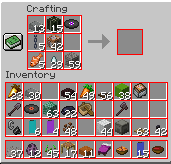

In [4]:
from PIL import Image, ImageDraw
from torchvision import transforms
import torch
from train_fast_rcnn import slot_to_bbox, sample_starting_inv

starting_inv = sample_starting_inv()
env.fast_reset(new_inventory=starting_inv)
obs, _, _, _ = env.step(env.action_space.no_op())

img = Image.fromarray(obs["pov"])
for item in obs["inventory"]:
    draw = ImageDraw.Draw(img)
    bbox = slot_to_bbox(item["index"])
    draw.rectangle(bbox, outline="red")

img_tensor = transforms.ToTensor()(obs["pov"].copy()).cuda()
# with torch.no_grad():
#     predictions = model(img_tensor.unsqueeze(0)) 

# for box_idx in range(len(predictions[0]["boxes"])):
#     if predictions[0]["scores"][box_idx] < 0.3:
#         continue
#     box = predictions[0]["boxes"][box_idx]
#     label = predictions[0]["labels"][box_idx]
#     draw = ImageDraw.Draw(img)
#     draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="blue")
#     # add text label in middle of box
#     draw.text(
#         (box[0].item() + (box[2].item() - box[0].item()) / 2, box[1].item() + (box[3].item() - box[1].item()) / 2),
#         str(label.item()),
#         fill="green",
#     )
# # show
img.show()

891

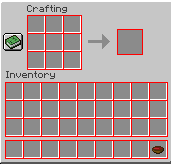

In [7]:
from PIL import Image, ImageDraw
from train_fast_rcnn import slot_to_bbox, sample_starting_inv

from torchvision import transforms
from PIL import Image, ImageDraw


img = Image.fromarray(obs["pov"])
for item in obs["inventory"]:
    draw = ImageDraw.Draw(img)
    bbox = slot_to_bbox(item["index"])
    draw.rectangle(bbox, outline="red")

# img_tensor = transforms.ToTensor()(obs["pov"].copy()).cuda()
# with torch.no_grad():
#     predictions = model(img_tensor.unsqueeze(0)) 

# print(predictions)

# for box_idx in range(len(predictions[0]["boxes"])):
#     if predictions[0]["scores"][box_idx] < 0.3:
#         continue
#     box = predictions[0]["boxes"][box_idx]
#     label = predictions[0]["labels"][box_idx]
#     draw = ImageDraw.Draw(img)
#     draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="blue")
#     # add text label in middle of box
#     draw.text(
#         (box[0].item() + (box[2].item() - box[0].item()) / 2, box[1].item() + (box[3].item() - box[1].item()) / 2),
#         str(label.item()+1),
#         fill="red",
#     )

img.show()

In [87]:
obs["inventory"]

[{'type': 'air', 'quantity': 0, 'index': 0},
 {'type': 'infested_stone_bricks', 'quantity': 35, 'index': 1},
 {'type': 'stripped_spruce_log', 'quantity': 59, 'index': 2},
 {'type': 'terracotta', 'quantity': 59, 'index': 3},
 {'type': 'air', 'quantity': 0, 'index': 4},
 {'type': 'warped_hyphae', 'quantity': 32, 'index': 5},
 {'type': 'air', 'quantity': 0, 'index': 6},
 {'type': 'orange_terracotta', 'quantity': 36, 'index': 7},
 {'type': 'air', 'quantity': 0, 'index': 8},
 {'type': 'air', 'quantity': 0, 'index': 9},
 {'type': 'salmon_spawn_egg', 'quantity': 47, 'index': 10},
 {'type': 'polished_diorite_slab', 'quantity': 40, 'index': 11},
 {'type': 'pufferfish_spawn_egg', 'quantity': 41, 'index': 12},
 {'type': 'prismarine_wall', 'quantity': 3, 'index': 13},
 {'type': 'air', 'quantity': 0, 'index': 14},
 {'type': 'cornflower', 'quantity': 41, 'index': 15},
 {'type': 'warped_pressure_plate', 'quantity': 34, 'index': 16},
 {'type': 'warped_stairs', 'quantity': 42, 'index': 17},
 {'type': '

In [5]:
from torchvision import transforms
from PIL import Image, ImageDraw

model.eval()

idx = 0
img_tensor = transforms.ToTensor()(data[idx]["pov"].copy()).cuda()

with torch.no_grad():
    predictions = model(img_tensor.unsqueeze(0))  

img = Image.fromarray(data[idx]["pov"])
for item in data[-1]["inventory"]:
    draw = ImageDraw.Draw(img)
    draw.rectangle(item["bbox"], outline="red")

for box_idx in range(len(predictions[0]["boxes"])):
    if predictions[0]["scores"][box_idx] < 0.5:
        continue
    box = predictions[0]["boxes"][box_idx]
    label = predictions[0]["labels"][box_idx]
    draw = ImageDraw.Draw(img)
    draw.rectangle([box[0].item(), box[1].item(), box[2].item(), box[3].item()], outline="blue")

    # add text label in middle of box
    draw.text(
        (box[0].item() + (box[2].item() - box[0].item()) / 2, box[1].item() + (box[3].item() - box[1].item()) / 2),
        str(label.item()+1),
        fill="red",
    )

img.show()

IndexError: list index out of range

In [1]:
def tmp():
    n = 0
    while n < 10:
        if n == 5:
            return
        yield n
        n += 1

for i in tmp():
    print(i) 

0
1
2
3
4


tensor([[[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.7765,  ..., 0.7765, 0.7765, 0.7765],
          ...,
          [1.0000, 0.7765, 0.7765,  ..., 0.7765, 0.7765, 0.3333],
          [0.7765, 0.3333, 0.3333,  ..., 0.3333, 0.3333, 0.3333],
          [0.0000, 0.3333, 0.3333,  ..., 0.3333, 0.3333, 0.3333]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.7765,  ..., 0.7765, 0.7765, 0.7765],
          ...,
          [1.0000, 0.7765, 0.7765,  ..., 0.7765, 0.7765, 0.3333],
          [0.7765, 0.3333, 0.3333,  ..., 0.3333, 0.3333, 0.3333],
          [0.0000, 0.3333, 0.3333,  ..., 0.3333, 0.3333, 0.3333]],

         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.7765,  ..., 0

In [128]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class InventoryDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.transform(self.data[idx]["pov"].copy())
        target = {
            "labels": [],
            "boxes": []
        }

        for i in self.data[idx]["inventory"]:
            target["labels"].append(i["quantity"])
            target["boxes"].append(i["bbox"])
        
        target["labels"] = torch.tensor(target["labels"], dtype=torch.int64)-1
        target["boxes"] = torch.tensor(target["boxes"], dtype=torch.int64)
        
        return img, target
    
# N = len(data)
train_dataset = InventoryDataset(data)
# val_dataset = InventoryDataset(data[int(N*0.9):])

In [123]:
import wandb
wandb.require("core")

In [130]:
import wandb
from torch.utils.data import DataLoader

num_epochs = 10
batch_size = 2
lr = 0.005

def collate_fn(batch):
    image_stack = []
    target_stack = []
    for img, target in batch:
        image_stack.append(img)
        target_stack.append(target)
    return torch.stack(image_stack), target_stack


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, collate_fn=collate_fn)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, collate_fn=collate_fn)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

wandb.init(project="plancraft-img-encoder", entity="itl")

batch_num = 1
for epoch in range(num_epochs):
    model.train()
    for imgs, labels in train_loader:
        imgs = imgs.cuda()
        for i in range(len(labels)):
            labels[i]["boxes"] = labels[i]["boxes"].cuda()
            labels[i]["labels"] = labels[i]["labels"].cuda()
        loss_dict = model(imgs, labels)
        wandb.log(loss_dict)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        batch_num += 1
        if batch_num % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_num}, Loss: {losses}")

    # model.eval()
    # with torch.no_grad():
    #     for imgs, labels in val_loader:
    #         imgs = imgs.cuda()
    #         for i in range(len(labels)):
    #             labels[i]["boxes"] = labels[i]["boxes"].cuda()
    #             labels[i]["labels"] = labels[i]["labels"].cuda()

    #         loss_dict = model(imgs, labels)

    #         val_loss_dict = {}
    #         for k, v in loss_dict.items():
    #             val_loss_dict[f"val_{k}"] = v.item()
    #         wandb.log(val_loss_dict)

    #         losses = sum(loss for loss in loss_dict.values())
    # print(f"Epoch {epoch}, Loss: {losses}")

# wandb.finish()

/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [5]:
class GenerativeDataset:
    def __iter__(self):
        return self
    def __next__(self):
        return 1

a = GenerativeDataset()

c = 0
for i in a:
    print(i)
    c += 1
    if c == 10:
        break


1
1
1
1
1
1
1
1
1
1


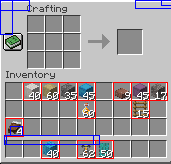

In [13]:
losses = sum(loss for loss in loss_dict.values())

In [55]:
# data[0]["pov"]
torch.tensor([1])

tensor([1])

1

In [33]:
help(model.forward)

Help on method forward in module torchvision.models.detection.generalized_rcnn:

forward(images, targets=None) method of torchvision.models.detection.faster_rcnn.FasterRCNN instance
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            During training, it returns a dict[Tensor] which contains the losses.
            During testing, it returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).



In [89]:
import glob
import numpy as np
from PIL import Image, ImageSequence

observed_data = []

for f in glob.glob("/plancraft/outputs/oracle_real/train/0/*.json"):
    with open(f, "r") as file:
        inventories = json.load(file)["model_trace"]["inventory_history"]
    gif_path = str(f).replace(".json", ".gif")
    # load gif as list of images
    gif = Image.open(gif_path)
    frames = [frame.copy() for frame in ImageSequence.Iterator(gif)]
    if len(frames) != len(inventories):
        print(f)
    else:
        for frame, inv in zip(frames, inventories):
            clean_inv = []
            for item in inv:
                if item["quantity"] > 0:
                    clean_inv.append(
                        {
                            "type": item["type"],
                            "slot": item["index"],
                            "quantity": item["quantity"],
                            "bbox": slot_to_bbox(item["index"]),
                        }
                    )
            observed_data.append(
                {"inventory": clean_inv, "pov": np.array(frame.convert("RGB"))}
            )
    # assert len(frames) == len(inv), (len(frames), len(inv))

/plancraft/outputs/oracle_real/train/0/TRAIN0157.json
/plancraft/outputs/oracle_real/train/0/TRAIN0071.json


In [125]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms


class InventoryDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((224, 224)),  # Resize images to 224x224
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        pov = item["pov"]
        pov = self.transform(pov)

        inventory = item["inventory"]
        types = [i["type"] for i in inventory]
        slots = [i["slot"] for i in inventory]
        quantities = [i["quantity"] for i in inventory]
        bboxes = [i["bbox"] for i in inventory]

        return pov, types, slots, quantities, bboxes


def collate_fn(batch):
    return tuple(zip(*batch))

dataset = InventoryDataset(observed_data)
train_loader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
)
batch = next(iter(train_loader))

In [135]:
import torch.nn as nn
import torchvision.models as models

class InventoryModel(nn.Module):
    def __init__(self, num_types, num_slots):
        super(InventoryModel, self).__init__()
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()  # Remove the classification layer

        # Bounding box head
        self.bbox_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 4),  # 4 coordinates for the bounding box
        )

        # Slot index prediction head
        self.slot_head = nn.Sequential(
            nn.Linear(512, 128), nn.ReLU(), nn.Linear(128, num_slots), nn.Softmax(dim=1)
        )

        # Quantity prediction head
        self.quantity_head = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Softmax(dim=1), 
        )

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad) // 1000000

    def forward(self, x):
        features = self.backbone(x)
        bbox = self.bbox_head(features)
        # types = self.type_head(features)
        slots = self.slot_head(features)
        quantity = self.quantity_head(features)
        return bbox, slots, quantity


# Example usage
model = InventoryModel(num_types=100, num_slots=45)  # Replace with actual numbers
model = model.cuda()
# Count number of parameters
print(f"Model has {model.count_parameters()}M parameters")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model has 11M parameters


# Get oracle O,A Dialogues

In [1]:
import json
import glob
import numpy as np
from PIL import Image, ImageSequence

oracle_trajectories_train = []
oracle_results = {
    "/plancraft/outputs/oracle_real/train/0/*.json": [],
    "/plancraft/outputs/oracle_real/val/0/*.json": [],
}
for path in oracle_results.keys():
    for f in glob.glob(path):
        with open(f, "r") as file:
            traj = json.load(file)

        images = []
        gif_path = str(f).replace(".json", ".gif")
        gif = Image.open(gif_path)
        for frame in ImageSequence.Iterator(gif):
            images.append(np.array(frame.convert("RGB")))
        traj["model_trace"]["images"] = images

        if (
            len(traj["model_trace"]["images"])
            == len(traj["model_trace"]["inventory_history"])
            == len(traj["model_trace"]["action_history"])
        ):
            oracle_results[path].append(traj)
        else:
            print(f)

In [26]:
import os
from plancraft.models.react_prompts import REACT_SYSTEM_PROMPT
from collections import defaultdict


def convert_obs_to_text(objective: str, inventory: list[dict]):
    return f"TASK: {objective}\ninventory={json.dumps(inventory)}"


def convert_action_to_text(action: dict):
    # {'action_type': 'move', 'slot_from': 17, 'slot_to': 1, 'quantity': 1}
    return f"act: {action['action_type']} from slot {action['slot_from']} to slot {action['slot_to']} with quantity {action['quantity']}"


# convert action and inventory to dialogue history
def convert_trajectory_to_base_dialogue(traj: dict):
    dialogue = [{"role": "system", "content": REACT_SYSTEM_PROMPT}]
    objective = traj["model_trace"]["objective"]
    for _, action, inventory in zip(
        traj["model_trace"]["images"],
        traj["model_trace"]["action_history"],
        traj["model_trace"]["inventory_history"],
    ):
        dialogue.append(
            {
                "role": "user",
                "content": convert_obs_to_text(objective, inventory),
            }
        )
        dialogue.append(
            {
                "role": "assistant",
                "content": convert_action_to_text(action),
            }
        )
    example = {
        "messages": dialogue,
        "example_id": traj["example_id"],
    }
    return example


# convert action and inventory to dialogue history
def convert_trajectory_to_image_dialogue(traj: dict):
    dialogue = [
        {"role": "system", "content": [{"type": "text", "text": REACT_SYSTEM_PROMPT}]}
    ]
    objective = traj["model_trace"]["objective"]
    images = []
    for image, action, inventory in zip(
        traj["model_trace"]["images"],
        traj["model_trace"]["action_history"],
        traj["model_trace"]["inventory_history"],
    ):
        dialogue.append(
            {
                "role": "user",
                "content": [{"type": "image"}, {"type": "text", "text": objective}],
            }
        )
        dialogue.append(
            {
                "role": "assistant",
                "content": [{"type": "text", "text": convert_action_to_text(action)}],
            }
        )
        images.append(image)
    example = {
        "messages": dialogue,
        "example_id": traj["example_id"],
    }
    return example, images


text_data = defaultdict(list)
mm_data = defaultdict(list)
for path, trajs in oracle_results.items():
    split = path.split("/")[-3]
    for traj in trajs:
        text_example = convert_trajectory_to_base_dialogue(traj)
        text_data[split].append(text_example)
        mm_example, example_imgs = convert_trajectory_to_image_dialogue(traj)
        mm_data[split].append(mm_example)
        # save imgs as png in format "data/oracle/{split}/{example_id}_{step}.gif"
        os.makedirs(f"data/oracle/{split}", exist_ok=True)
        for i, img in enumerate(example_imgs):
            Image.fromarray(img).save(
                f"data/oracle/{split}/{traj['example_id']}_{i}.png"
            )

    # save as jsonl file
    with open(f"data/oracle/{split}.jsonl", "w") as f:
        for example in text_data[split]:
            f.write(json.dumps(example) + "\n")

    with open(f"data/oracle/{split}.mm.jsonl", "w") as f:
        for example in mm_data[split]:
            f.write(json.dumps(example) + "\n")

# Generate Thought traces

In [1]:
import json
import pandas as pd

split = "train"
with open(f"data/{split}.json", "r") as f:
    examples = json.load(f)
df = pd.DataFrame(examples)

dialogues = []
with open(f"data/oracle/{split}.jsonl", "r") as f:
    for line in f:
        dialogues.append(json.loads(line))

dialogue_df = pd.DataFrame(dialogues)

df = pd.merge(df, dialogue_df, left_on="id", right_on="example_id", how="inner")

In [16]:
BASE_PROMPT = """
You are crafting in Minecraft.

The first 10 slots in the inventory are reserved for crafting and correspond to the minecraft crafting table.
[1, 2, 3]
[4, 5, 6] -> [0]
[7, 8, 9]

The crafting matrix is a 3x3 grid, and the output is sent to slot 0.
You cannot move or smelt items into output slot 0.
The remaining slots (10-45) are for storing items.

For a given observation action pair, you should explain the reasoning behind taking that action. Mention the state of the environment, what the next recipe to craft is (in the context of the greater planning problem) and why this move should be taken.

Examples:

TASK: Craft an item of type: andesite
Crafting path: [andesite]

1. inventory='[{"type": "diorite", "slot": 27, "quantity": 1},{"type": "cobblestone", "slot": 39, "quantity": 1}]'
action: move from slot 27 to slot 4 with quantity 1
thought: To solve this task I need to craft andesite. Andesite requires placing 1 diorite and 1 cobblestone side by side in the crafting table, therefore I will first need to move the diorite from slot 27 into the crafting grid. 

2. inventory=[{"type": "diorite", "slot": 4, "quantity": 1},{"type": "cobblestone", "slot": 39, "quantity": 1}]
action: move from slot 39 to slot 5 with quantity 1
thought: Since the diorite has been moved into the crafting grid, I now need to move the cobblestone to the right of it. Slot 5 is to the right of slot 4, and therefore I will move the cobblestone to slot 5.

3. inventory=[{"type": "andesite", "slot": 0, "quantity": 1},{"type": "diorite", "slot": 4, "quantity": 1},{"type": "cobblestone", "slot": 5, "quantity": 1}]
action: move from slot 0 to slot 15 with quantity 1
thought: Now I can craft the andesite by moving it from the craft slot (0) to a free inventory slot (eg., 15). 

TASK: Craft an item of type: iron_ingot
Crafting path: [iron_ingot]

1. inventory='[{"type": "iron_ore", "slot": 45, "quantity": 1},{"type": "cobblestone", "slot": 39, "quantity": 1}]
action: smelt from slot 45 to slot 44 with quantity 1
thought: To craft an iron_ingot, I need to smelt the iron_ore at slot 45 into an empty slot (eg., 44).

"""

In [3]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "/nfs/public/hf/models/meta-llama/Meta-Llama-3-70B"
tokenizer = AutoTokenizer.from_pretrained(model_name, local_files_only=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    local_files_only=True,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 30/30 [00:24<00:00,  1.24it/s]


In [12]:
from transformers import StopStringCriteria, StoppingCriteriaList

stopping_criteria = StoppingCriteriaList([StopStringCriteria(
    tokenizer=tokenizer, stop_strings=["\n", "\n\n", ".\n\n", "\n\n\n"]
)])

In [19]:
def generate_thoughts(row):
    step = 1
    task_message = BASE_PROMPT + row.messages[1]["content"].split("\n")[0]
    task_message += f"\nCrafting path: {row.optimal_path}"
    OTA_messages = []
    for i in range(1, len(row.messages), 2):
        user_entry = row.messages[i]
        assert user_entry["role"] == "user"
        assistant_entry = row.messages[i + 1]
        assert assistant_entry["role"] == "assistant"
        inventory = user_entry["content"].split("inventory=")[1]
        action = assistant_entry["content"]
        task_message += f"\n\n{step}. inventory={inventory}\naction: {action}\nthought:"
        tokenized_prompt = tokenizer(task_message, return_tensors="pt")
        outputs = model.generate(
            **tokenized_prompt,
            tokenizer=tokenizer,
            max_new_tokens=128,
            do_sample=True,
            temperature=0.6,
            top_p=0.9,
            stopping_criteria=[stopping_criteria],
        )
        # Decode the generated output
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True).rstrip(
            "\n"
        )
        thought = generated_text.split("thought:")[-1].strip()
        OTA_messages.append(user_entry)  # Observation
        OTA_messages.append({"role": "assistant", "content": f"thought: {thought}"})  # Thought
        OTA_messages.append({"role": "user", "content": "Ok"})
        OTA_messages.append(assistant_entry) # Action
        task_message = generated_text
        step += 1
    return OTA_messages

# Convert and print the result
output = generate_thoughts(df.iloc[0])
print(output)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1797: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


[{'role': 'user', 'content': 'TASK: Craft an item of type: red_dye\ninventory=[{"type": "torch", "quantity": 57, "index": 19}, {"type": "wooden_pickaxe", "quantity": 1, "index": 21}, {"type": "map", "quantity": 22, "index": 26}, {"type": "beetroot", "quantity": 1, "index": 35}, {"type": "lodestone", "quantity": 50, "index": 36}]'}, {'role': 'assistant', 'content': 'To craft a red_dye, I need to move the beetroot from slot 35 to slot 1.'}, {'role': 'user', 'content': 'Ok'}, {'role': 'assistant', 'content': 'act: move from slot 35 to slot 1 with quantity 1'}, {'role': 'user', 'content': 'TASK: Craft an item of type: red_dye\ninventory=[{"type": "red_dye", "quantity": 1, "index": 0}, {"type": "beetroot", "quantity": 1, "index": 1}, {"type": "torch", "quantity": 57, "index": 19}, {"type": "wooden_pickaxe", "quantity": 1, "index": 21}, {"type": "map", "quantity": 22, "index": 26}, {"type": "lodestone", "quantity": 50, "index": 36}]'}, {'role': 'assistant', 'content': 'Now that the red_dye i

In [24]:
df.iloc[0]["id"]

'TRAIN0001'